In [1]:
# all the imports necessary for analysis
from yahoo_fin.stock_info import *
import pandas as pd
from scipy.stats import gmean
import numpy as np
import cvxpy as cp
import pandas as pd
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import HRPOpt
from pypfopt.efficient_frontier import EfficientCVaR
from scipy.optimize import minimize
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
import datetime as dt
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import Timestamp

# setting no. of trading days
no_trading_days = 252


### Defining a function to extract, clean and represent all historical data on ETF in a suitable dataframe

In [2]:
# defining a function to generate a cleaned up dataframe for a given ticker symbol

def get_etf_info(ticker):
    #df to capture prices
    etf_prices = get_data(ticker)

    # df to capture dividends
    etf_dividends = get_dividends(ticker)

    # only taking columns needed
    etf_prices = etf_prices[['adjclose', 'volume', 'ticker']]

    # merging price and dividend df's to calculate total return
    etf_info = pd.merge(etf_prices, etf_dividends, left_index=True, right_index=True, how = 'left')
    del etf_info['ticker_y']
    etf_info.fillna(0, inplace=True)

    # renaming & reordering columns
    etf_info.columns=['close_price','trading_volume','ticker_symbol','dividend']
    etf_info=etf_info[['ticker_symbol','close_price','dividend','trading_volume']]

    # calculating daily return 
    etf_info['daily_return'] = etf_info['close_price'].pct_change() * 100

    # calculating dividend return
    etf_info['dividend_return']= (etf_info['dividend']/etf_info['close_price'])*100

    # calculating total return
    etf_info['total_return']=etf_info['daily_return']+etf_info['dividend_return']

    # dropping first row
    etf_info=etf_info.drop(etf_info.index[0])
    
    return etf_info

### Defining functions to return expected annualized return and risk

In [3]:
def get_annualized_return(ticker):
    etf_info = get_etf_info(ticker)
    etf_annualized_return = etf_info['total_return'].mean() * no_trading_days
    return etf_annualized_return

In [4]:
def get_annualized_risk(ticker):
    etf_info = get_etf_info(ticker)
    etf_annualized_stddev = np.sqrt(etf_info['total_return'].var() * no_trading_days)
    return etf_annualized_stddev

### Assigning the 5 ETFs to allocate for the portfolio

In [5]:
# selected ETF list

etf_list = ['BOND', 'SPY', 'VGK', 'SCHE', 'VONG']

In [6]:
# looping through ETF list and gathering data for each ETF

etf_info = {}
annualized_return = {}
annualized_risk = {}
for i, etf in enumerate(etf_list):
    etf_info[etf] = get_etf_info(etf)
    annualized_return[etf] = get_annualized_return(etf)
    annualized_risk[etf] = get_annualized_risk(etf)

### Pimco Active Bond Exchange-Traded Fund (BOND)

In [7]:
etf_info['BOND']

,ticker_symbol,close_price,dividend,trading_volume,daily_return,dividend_return,total_return
2012-03-02,BOND,69.966324,0.0,331600,0.350151,0.0,0.350151
2012-03-05,BOND,69.959328,0.0,237800,-0.009999,0.0,-0.009999
2012-03-06,BOND,70.273254,0.0,176500,0.448727,0.0,0.448727
2012-03-07,BOND,70.370888,0.0,182600,0.138934,0.0,0.138934
2012-03-08,BOND,70.817253,0.0,323000,0.634304,0.0,0.634304
...,...,...,...,...,...,...,...
2023-09-22,BOND,88.730003,0.0,113900,0.327907,0.0,0.327907
2023-09-25,BOND,88.050003,0.0,116100,-0.766370,0.0,-0.766370
2023-09-26,BOND,87.949997,0.0,182400,-0.113579,0.0,-0.113579
2023-09-27,BOND,87.730003,0.0,500500,-0.250135,0.0,-0.250135


In [8]:
annualized_return['BOND']

5.8666508075050965

In [9]:
annualized_risk['BOND']

4.788522449977892

### SPDR S&P 500 ETF Trust (SPY)

In [10]:
etf_info['SPY']

,ticker_symbol,close_price,dividend,trading_volume,daily_return,dividend_return,total_return
1993-02-01,SPY,25.118790,0.0,480500,0.711262,0.0,0.711262
1993-02-02,SPY,25.171997,0.0,201300,0.211823,0.0,0.211823
1993-02-03,SPY,25.438089,0.0,529400,1.057097,0.0,1.057097
1993-02-04,SPY,25.544525,0.0,531500,0.418411,0.0,0.418411
1993-02-05,SPY,25.526798,0.0,492100,-0.069396,0.0,-0.069396
...,...,...,...,...,...,...,...
2023-09-22,SPY,430.420013,0.0,100757900,-0.224855,0.0,-0.224855
2023-09-25,SPY,432.230011,0.0,70874500,0.420519,0.0,0.420519
2023-09-26,SPY,425.880005,0.0,96168400,-1.469127,0.0,-1.469127
2023-09-27,SPY,426.049988,0.0,104705800,0.039913,0.0,0.039913


In [11]:
annualized_return['SPY']

13.543425817307703

In [12]:
annualized_risk['SPY']

18.839903802705454

### Vanguard FTSE Europe ETF (VGK)

In [13]:
etf_info['VGK']

,ticker_symbol,close_price,dividend,trading_volume,daily_return,dividend_return,total_return
2005-03-11,VGK,25.749510,0.0,25200,0.000000,0.0,0.000000
2005-03-14,VGK,25.724222,0.0,26600,-0.098206,0.0,-0.098206
2005-03-15,VGK,25.648340,0.0,34900,-0.294983,0.0,-0.294983
2005-03-16,VGK,25.547155,0.0,9700,-0.394508,0.0,-0.394508
2005-03-17,VGK,25.547155,0.0,12500,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...
2023-09-22,VGK,58.669998,0.0,2275800,-0.221090,0.0,-0.221090
2023-09-25,VGK,58.270000,0.0,1775100,-0.681776,0.0,-0.681776
2023-09-26,VGK,57.540001,0.0,3416700,-1.252788,0.0,-1.252788
2023-09-27,VGK,57.290001,0.0,3013800,-0.434480,0.0,-0.434480


In [14]:
annualized_return['VGK']

12.451464289071716

In [15]:
annualized_risk['VGK']

24.247226252518896

### Schwab Emerging Markets Equity ETF (SCHE)

In [16]:
etf_info['SCHE']

,ticker_symbol,close_price,dividend,trading_volume,daily_return,dividend_return,total_return
2010-01-15,SCHE,18.032835,0.0,344000,-1.618604,0.0,-1.618604
2010-01-19,SCHE,18.278868,0.0,231700,1.364360,0.0,1.364360
2010-01-20,SCHE,17.873634,0.0,198300,-2.216950,0.0,-2.216950
2010-01-21,SCHE,17.294731,0.0,177100,-3.238867,0.0,-3.238867
2010-01-22,SCHE,16.976332,0.0,58400,-1.841020,0.0,-1.841020
...,...,...,...,...,...,...,...
2023-09-22,SCHE,24.219999,0.0,1655700,1.211864,0.0,1.211864
2023-09-25,SCHE,24.100000,0.0,1634300,-0.495454,0.0,-0.495454
2023-09-26,SCHE,23.830000,0.0,1348500,-1.120334,0.0,-1.120334
2023-09-27,SCHE,23.860001,0.0,2455900,0.125895,0.0,0.125895


In [17]:
annualized_return['SCHE']

6.915758711274504

In [18]:
annualized_risk['SCHE']

21.140812486835035

### Vanguard Russell 1000 Growth ETF (VONG)

In [19]:
etf_info['VONG']

,ticker_symbol,close_price,dividend,trading_volume,daily_return,dividend_return,total_return
2010-09-23,VONG,11.154119,0.0,65200,0.270223,0.0,0.270223
2010-09-24,VONG,11.291533,0.0,70400,1.231957,0.0,1.231957
2010-09-27,VONG,11.325884,0.0,46800,0.304222,0.0,0.304222
2010-09-28,VONG,11.325884,0.0,0,0.000000,0.0,0.000000
2010-09-29,VONG,11.317298,0.0,86800,-0.075808,0.0,-0.075808
...,...,...,...,...,...,...,...
2023-09-22,VONG,68.629997,0.0,453500,-0.058251,0.0,-0.058251
2023-09-25,VONG,68.989998,0.0,550800,0.524553,0.0,0.524553
2023-09-26,VONG,67.860001,0.0,725000,-1.637915,0.0,-1.637915
2023-09-27,VONG,67.959999,0.0,785100,0.147360,0.0,0.147360


In [20]:
annualized_return['VONG']

17.051905665939657

In [21]:
annualized_risk['VONG']

18.990221138722763

### Defining a function to extract, clean and represent all historical data on ETF in a suitable dataframe from a given start date

Using a start date = 2012-03-02 to get datasets of the same size

In [22]:
def get_etf_info_dated(ticker, start_date):
    #df to capture prices
    etf_prices = get_data(ticker, start_date = start_date)

    # df to capture dividends
    etf_dividends = get_dividends(ticker, start_date = start_date)

    # only taking columns needed
    etf_prices = etf_prices[['adjclose', 'volume', 'ticker']]

    # merging price and dividend df's to calculate total return
    etf_info = pd.merge(etf_prices, etf_dividends, left_index=True, right_index=True, how = 'left')
    del etf_info['ticker_y']
    etf_info.fillna(0, inplace=True)

    # renaming & reordering columns
    etf_info.columns=['close_price','trading_volume','ticker_symbol','dividend']
    etf_info=etf_info[['ticker_symbol','close_price','dividend','trading_volume']]

    # calculating daily return 
    etf_info['daily_return'] = etf_info['close_price'].pct_change() 

    # calculating dividend return
    etf_info['dividend_return']= (etf_info['dividend']/etf_info['close_price'])

    # calculating total return
    etf_info['total_return']=etf_info['daily_return']+etf_info['dividend_return']

    # dropping first row
    etf_info=etf_info.drop(etf_info.index[0])
    
    return etf_info

### Defining a function to extract just the returns of the ETFs

In [23]:
def get_etf_returns(ticker, start_date):
    etf_info = get_etf_info_dated(ticker, start_date)
    return etf_info['total_return']

In [24]:
etf_data = pd.DataFrame()
start_date = '2012-03-02'

for etf in etf_list:
    column_name = f"{etf}_total_returns"
    etf_data[column_name] = get_etf_returns(etf, start_date)

etf_data

,BOND_total_returns,SPY_total_returns,VGK_total_returns,SCHE_total_returns,VONG_total_returns
2012-03-05,-0.000099,-0.004079,-0.003907,-0.014920,-0.005454
2012-03-06,0.004486,-0.014625,-0.040967,-0.033699,-0.015537
2012-03-07,0.001389,0.006976,0.015905,0.011756,0.007736
2012-03-08,0.006344,0.009949,0.027063,0.018977,0.011208
2012-03-09,-0.002265,0.003868,-0.010017,0.000000,0.003644
...,...,...,...,...,...
2023-09-22,0.003279,-0.002249,-0.002211,0.012119,-0.000583
2023-09-25,-0.007664,0.004205,-0.006818,-0.004955,0.005246
2023-09-26,-0.001136,-0.014691,-0.012528,-0.011203,-0.016379
2023-09-27,-0.002501,0.000399,-0.004345,0.001259,0.001474


In [25]:
etf_data.cov()

,BOND_total_returns,SPY_total_returns,VGK_total_returns,SCHE_total_returns,VONG_total_returns
BOND_total_returns,0.000009,0.000003,0.000004,0.000004,0.000004
SPY_total_returns,0.000003,0.000113,0.000106,0.000100,0.000120
VGK_total_returns,0.000004,0.000106,0.000146,0.000118,0.000108
SCHE_total_returns,0.000004,0.000100,0.000118,0.000160,0.000107
VONG_total_returns,0.000004,0.000120,0.000108,0.000107,0.000141


### Minimum Variance Portfolio (SciPy)
Calculating target_return values of 25%, 20%, 15%, 10%, 7%, 5% and 3%.

In [26]:
target_return_list = [0.25, 0.2, 0.15, 0.1, 0.07, 0.05, 0.03]

In [27]:
def min_variance_port_scipy(target_return):
    # Define the expected returns and risk (standard deviation) and covariance matrix
    expected_returns = (np.array(list(annualized_return.values())))/100
    risk = (np.array(list(annualized_return.values())))/100
    covariance_matrix = np.array(etf_data.cov())*no_trading_days

    # Define the objective function to minimize portfolio variance
    def portfolio_variance(weights):
        portfolio_return = np.dot(weights, expected_returns)
        portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
        return portfolio_stddev

    # Define the constraint that the portfolio return must equal the target return
    def return_constraint(weights):
        return np.dot(weights, expected_returns) - target_return

    # Define the constraint that the sum of weights equals 1 (fully invested)
    def weight_constraint(weights):
        return np.sum(weights) - 1.0

    # Initial guess for portfolio weights (equal weights)
    initial_weights = np.ones(len(expected_returns)) / len(expected_returns)

    # Define bounds for portfolio weights (0 <= weight <= 1)
    bounds = [(0, 1)] * len(expected_returns)

    # Define constraints
    constraints = [
        {'type': 'eq', 'fun': return_constraint},
        {'type': 'eq', 'fun': weight_constraint}
    ]

    # Run the optimization to find the minimum variance portfolio
    result = minimize(portfolio_variance, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

    # Extract the optimal portfolio weights
    optimal_weights = result.x

    # Print the optimal weights
    print('Target Return: ', target_return)
    print("Optimal Portfolio Weights:")
    for i, weight in enumerate(optimal_weights):
        print(f"{etf_list[i]}: {weight:.4f}")

    # Print the minimum variance achieved
    print(f"Minimum Portfolio Variance: {result.fun:.6f}")
    print("----------------------------------------------")


In [28]:
for target in target_return_list:
    min_variance_port_scipy(target)

Target Return:  0.25
Optimal Portfolio Weights:
BOND: 0.0000
SPY: 0.0000
VGK: 0.0000
SCHE: 0.0000
VONG: 1.0000
Minimum Portfolio Variance: 0.188242
----------------------------------------------
Target Return:  0.2
Optimal Portfolio Weights:
BOND: 0.0000
SPY: 0.0000
VGK: 0.0000
SCHE: 0.0000
VONG: 1.0000
Minimum Portfolio Variance: 0.188242
----------------------------------------------
Target Return:  0.15
Optimal Portfolio Weights:
BOND: 0.1834
SPY: 0.0000
VGK: 0.0000
SCHE: 0.0000
VONG: 0.8166
Minimum Portfolio Variance: 0.155013
----------------------------------------------
Target Return:  0.1
Optimal Portfolio Weights:
BOND: 0.6305
SPY: 0.0000
VGK: 0.0000
SCHE: 0.0000
VONG: 0.3695
Minimum Portfolio Variance: 0.079095
----------------------------------------------
Target Return:  0.07
Optimal Portfolio Weights:
BOND: 0.8946
SPY: 0.0130
VGK: 0.0000
SCHE: 0.0000
VONG: 0.0924
Minimum Portfolio Variance: 0.049118
----------------------------------------------
Target Return:  0.05
Optima

### Maximum Return Portfolio (SciPy)
Using desired_risk values of 5%, 10%, 15%, 20%, 25%.

In [29]:
desired_risk_list = [0.05, 0.1, 0.15, 0.2, 0.25]

In [30]:
def max_return_port_scipy(desired_risk):
    
    # Define the expected returns and risk (standard deviation) and covariance matrix 
    expected_returns = (np.array(list(annualized_return.values())))/100
    risk = (np.array(list(annualized_return.values())))/100
    covariance_matrix = np.array(etf_data.cov())*no_trading_days


    # Define the objective function to maximize portfolio return
    def portfolio_return(weights):
        return -np.dot(weights, expected_returns)  # Negative sign because we want to maximize

    # Define the constraint that the portfolio risk must be less than or equal to the desired risk
    def risk_constraint(weights):
        portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
        return portfolio_stddev - desired_risk

    # Define the constraint that the sum of weights equals 1 (fully invested)
    def weight_constraint(weights):
        return np.sum(weights) - 1.0

    # Initial guess for portfolio weights (equal weights)
    initial_weights = np.ones(len(expected_returns)) / len(expected_returns)

    # Define bounds for portfolio weights (0 <= weight <= 1)
    bounds = [(0, 1)] * len(expected_returns)

    # Define constraints
    constraints = [
        {'type': 'eq', 'fun': risk_constraint},
        {'type': 'eq', 'fun': weight_constraint}
    ]

    # Run the optimization to find the maximum return portfolio within the specified risk range
    result = minimize(portfolio_return, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

    # Extract the optimal portfolio weights
    optimal_weights = result.x

    # Calculate the maximum return achieved (negative sign reversed)
    max_return = -result.fun

    # Print the optimal weights and maximum return
    print('Desired Risk: ', desired_risk)
    print("Optimal Portfolio Weights:")
    for i, weight in enumerate(optimal_weights):
        print(f"{etf_list[i]}: {weight:.4f}")
    print(f"Maximum Portfolio Return: {max_return:.6f}")
    print("---------------------------------------------")


In [31]:
for risk in desired_risk_list:
    max_return_port_scipy(risk)

Desired Risk:  0.05
Optimal Portfolio Weights:
BOND: 0.8825
SPY: 0.0000
VGK: 0.0000
SCHE: 0.0000
VONG: 0.1175
Maximum Portfolio Return: 0.071808
---------------------------------------------
Desired Risk:  0.1
Optimal Portfolio Weights:
BOND: 0.4992
SPY: 0.0000
VGK: 0.0000
SCHE: 0.0000
VONG: 0.5008
Maximum Portfolio Return: 0.114678
---------------------------------------------
Desired Risk:  0.15
Optimal Portfolio Weights:
BOND: 0.2114
SPY: 0.0000
VGK: 0.0000
SCHE: 0.0000
VONG: 0.7886
Maximum Portfolio Return: 0.146871
---------------------------------------------
Desired Risk:  0.2
Optimal Portfolio Weights:
BOND: 0.0000
SPY: 0.0000
VGK: 0.0000
SCHE: 0.9914
VONG: 0.0086
Maximum Portfolio Return: 0.070032
---------------------------------------------
Desired Risk:  0.25
Optimal Portfolio Weights:
BOND: 0.0000
SPY: 0.0000
VGK: 0.0000
SCHE: 1.0000
VONG: 0.0000
Maximum Portfolio Return: 0.069158
---------------------------------------------


### Minimum Variance Portfolio (CVXPY)
Note that this model allows for short selling.

Using target_return values of 25%, 20%, 15%, 10%, 7%, 5% and 3%.

In [32]:
def min_variance_port_cvxpy(target_return):
    
    # Define the expected returns and risk (standard deviation) and covariance matrix
    expected_returns = (np.array(list(annualized_return.values())))/100
    risk = (np.array(list(annualized_return.values())))/100
    covariance_matrix = np.array(etf_data.cov())*no_trading_days


    # Define the portfolio weights as variables to be optimized
    weights = cp.Variable(len(expected_returns))

    # Define the portfolio return and risk (standard deviation)
    portfolio_return = expected_returns @ weights
    portfolio_risk = cp.quad_form(weights, covariance_matrix)

    # Define the optimization problem to minimize portfolio risk
    objective = cp.Minimize(portfolio_risk)

    # Define the constraint for the target return
    constraints = [portfolio_return == target_return]

    # Define the constraint that the sum of weights equals 1 (fully invested)
    constraints += [cp.sum(weights) == 1]

    # Define the problem and solve it
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Extract the optimal portfolio weights
    optimal_weights = weights.value

    # Print the optimal weights
    print("Target Return: ", target_return)
    print("Optimal Portfolio Weights:")
    for i, weight in enumerate(optimal_weights):
        print(f"{etf_list[i]}: {weight:.4f}")

    # Print the minimum portfolio risk achieved (standard deviation)
    min_portfolio_risk = np.sqrt(problem.value)
    print(f"Minimum Portfolio Risk (Standard Deviation): {min_portfolio_risk:.6f}")
    print("------------------------------------------------------------------------")

In [33]:
for target in target_return_list:
    min_variance_port_cvxpy(target)

Target Return:  0.25
Optimal Portfolio Weights:
BOND: 0.4980
SPY: -1.6691
VGK: 0.6474
SCHE: -1.0498
VONG: 2.5735
Minimum Portfolio Risk (Standard Deviation): 0.224747
------------------------------------------------------------------------
Target Return:  0.2
Optimal Portfolio Weights:
BOND: 0.6142
SPY: -1.1775
VGK: 0.4725
SCHE: -0.7755
VONG: 1.8663
Minimum Portfolio Risk (Standard Deviation): 0.168944
------------------------------------------------------------------------
Target Return:  0.15
Optimal Portfolio Weights:
BOND: 0.7303
SPY: -0.6859
VGK: 0.2977
SCHE: -0.5012
VONG: 1.1591
Minimum Portfolio Risk (Standard Deviation): 0.114789
------------------------------------------------------------------------
Target Return:  0.1
Optimal Portfolio Weights:
BOND: 0.8465
SPY: -0.1943
VGK: 0.1228
SCHE: -0.2269
VONG: 0.4519
Minimum Portfolio Risk (Standard Deviation): 0.066446
------------------------------------------------------------------------
Target Return:  0.07
Optimal Portfolio Wei

### Maximum Return Portfolio (CVXPY)

Note that this model allows for short selling.

Using desired_risk values of 5%, 10%, 15%, 20%, 25%.


In [34]:
def max_return_port_cvxpy(desired_risk):
    
    # Define the expected returns and risk (standard deviation) and covariance matrix
    expected_returns = (np.array(list(annualized_return.values())))/100
    risk = (np.array(list(annualized_return.values())))/100
    covariance_matrix = np.array(etf_data.cov())*no_trading_days

    # Define the portfolio weights as variables to be optimized
    weights = cp.Variable(len(expected_returns))

    # Define the portfolio return
    portfolio_return = expected_returns @ weights

    # Define the portfolio risk (standard deviation)
    portfolio_risk = cp.quad_form(weights, covariance_matrix)

    # Define the optimization problem to maximize portfolio return
    objective = cp.Maximize(portfolio_return)

    # Define the constraint for the desired risk level
    constraints = [portfolio_risk <= (desired_risk ** 2)]

    # Define the constraint that the sum of weights equals 1 (fully invested)
    constraints += [cp.sum(weights) == 1]

    # Define the problem and solve it
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Extract the optimal portfolio weights
    optimal_weights = weights.value

    # Calculate the maximum portfolio return achieved
    max_portfolio_return = problem.value

    # Print the optimal weights and maximum portfolio return
    print("Desired Risk: ", desired_risk)
    print("Optimal Portfolio Weights:")
    for i, weight in enumerate(optimal_weights):
        print(f"Stock {i + 1}: {weight:.4f}")
    print(f"Maximum Portfolio Return: {max_portfolio_return:.6f}")
    print("------------------------------------------------------")


In [35]:
for risk in desired_risk_list:
    max_return_port_cvxpy(risk)

Desired Risk:  0.05
Optimal Portfolio Weights:
Stock 1: 0.9051
Stock 2: 0.0539
Stock 3: 0.0345
Stock 4: -0.0883
Stock 5: 0.0947
Maximum Portfolio Return: 0.074750
------------------------------------------------------
Desired Risk:  0.1
Optimal Portfolio Weights:
Stock 1: 0.7635
Stock 2: -0.5455
Stock 3: 0.2477
Stock 4: -0.4228
Stock 5: 0.9571
Maximum Portfolio Return: 0.135717
------------------------------------------------------
Desired Risk:  0.15
Optimal Portfolio Weights:
Stock 1: 0.6542
Stock 2: -1.0081
Stock 3: 0.4123
Stock 4: -0.6809
Stock 5: 1.6225
Maximum Portfolio Return: 0.182766
------------------------------------------------------
Desired Risk:  0.2
Optimal Portfolio Weights:
Stock 1: 0.5493
Stock 2: -1.4521
Stock 3: 0.5702
Stock 4: -0.9287
Stock 5: 2.2613
Maximum Portfolio Return: 0.227930
------------------------------------------------------
Desired Risk:  0.25
Optimal Portfolio Weights:
Stock 1: 0.4460
Stock 2: -1.8894
Stock 3: 0.7258
Stock 4: -1.1728
Stock 5: 2.890

### Mean-Variance Optimization (PyPortfolioOpt)

In [37]:
# creating a dataframe containing price info
etf_prices_df = pd.DataFrame(index = etf_data.index)

for etf in etf_list:
    etf_prices_df[etf] = get_etf_info_dated(etf, start_date).iloc[:, 1] 

etf_prices_df

,BOND,SPY,VGK,SCHE,VONG
2012-03-05,69.959320,109.892296,31.039801,19.758091,14.300100
2012-03-06,70.273224,108.285065,29.768183,19.092257,14.077918
2012-03-07,70.370819,109.040428,30.241667,19.316698,14.186831
2012-03-08,70.817253,110.125305,31.060091,19.683275,14.345841
2012-03-09,70.656845,110.551231,30.748957,19.683275,14.398122
...,...,...,...,...,...
2023-09-22,88.730003,430.420013,58.669998,24.219999,68.629997
2023-09-25,88.050003,432.230011,58.270000,24.100000,68.989998
2023-09-26,87.949997,425.880005,57.540001,23.830000,67.860001
2023-09-27,87.730003,426.049988,57.290001,23.860001,67.959999


In [38]:
# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(etf_prices_df)
S = risk_models.sample_cov(etf_prices_df)

# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
ef.save_weights_to_file("weights.csv")  # saves to file
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('BOND', 0.0), ('SPY', 0.0), ('VGK', 0.0), ('SCHE', 0.0), ('VONG', 1.0)])
Expected annual return: 14.5%
Annual volatility: 18.8%
Sharpe Ratio: 0.67


(0.14521145996932094, 0.18810633063615043, 0.6656419246809641)

### Heirarchal Risk Parity Portfolio (PyPortfolioOpt)

In [39]:
# using pre-existing HRP algorithm
returns = etf_prices_df.pct_change().dropna()
hrp = HRPOpt(returns)
hrp_weights = hrp.optimize()
hrp.portfolio_performance(verbose=True)
print(dict(hrp_weights))

Expected annual return: 2.7%
Annual volatility: 4.7%
Sharpe Ratio: 0.16
{'BOND': 0.886860163837999, 'SCHE': 0.04753360993223051, 'SPY': 0.01959600935697831, 'VGK': 0.030189241707346628, 'VONG': 0.01582097516544548}


### Mean Conditional Value at Risk (mCVAR)


In [40]:
# using pre-existing mCVAR code
S = etf_prices_df.cov()
ef_cvar = EfficientCVaR(mu, S)
cvar_weights = ef_cvar.min_cvar()

cleaned_weights = ef_cvar.clean_weights()
print(dict(cleaned_weights))

{'BOND': 0.0, 'SPY': 1.0, 'VGK': 0.0, 'SCHE': 0.0, 'VONG': 0.0}


### Monte Carlo Simulation Model
Simulating 100,000 different allocations.

In [168]:
# creating a dataframe of returns
returns_portfolio = etf_prices_df.pct_change()

In [169]:
# setting proxy weights for the portfolio
weight_portfolio = [0.2, 0.2, 0.3, 0.1, 0.2]

# calculating portfolio return based on proxy weights
portfolio_return = returns_portfolio.dot(weight_portfolio)
portfolio_return.head()

2012-03-05         NaN
2012-03-06   -0.020796
2012-03-07    0.009167
2012-03-08    0.015517
2012-03-09   -0.001956
dtype: float64

In [170]:
# created a covariance matrix (annualized)
cov_matrix = returns_portfolio.cov()*no_trading_days
cov_matrix

,BOND,SPY,VGK,SCHE,VONG
BOND,0.002094,0.000716,0.000983,0.001004,0.001055
SPY,0.000716,0.028566,0.026702,0.025279,0.030430
VGK,0.000983,0.026702,0.036188,0.029770,0.027302
SCHE,0.001004,0.025279,0.029770,0.039089,0.026900
VONG,0.001055,0.030430,0.027302,0.026900,0.035382


In [173]:
# calculating portfolio variance
portfolio_variance = np.transpose(weight_portfolio)@cov_matrix@weight_portfolio

# calculating portfolio std. deviation ie. risk, ie. volatility
portfolio_volatility = np.sqrt(portfolio_variance)

# creating empty lists to store returns, volatility, weights
port_returns = []
port_volatility=[]
port_weights =[]

num_assets = len(etf_prices_df.columns)

# setting no. of simulations
num_portfolios = 100000
individual_rets = etf_prices_df.resample('Y').last().pct_change().mean()

In [53]:
# generating simulated weights and calculating return and risk accordingly
for port in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    port_weights.append(weights)
    returns = np.dot(weights, individual_rets)
    port_returns.append(returns)
    
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
    sd = np.sqrt(var)
    ann_sd = sd*np.sqrt(250)
    port_volatility.append(ann_sd)

In [54]:
data = {'Returns':port_returns, 'Volatility':port_volatility}

for counter, symbol in enumerate(df.columns.tolist()):
    data[symbol + ' weight'] = [w[counter] for w in port_weights]

In [55]:
# creating a dataframe of the 100,000 simulated portfolios
portfolios_V1 = pd.DataFrame(data)
portfolios_V1

,Returns,Volatility,BOND weight,SPY weight,VGK weight,SCHE weight,VONG weight
0,0.093952,2.578394,0.063172,0.128089,0.359567,0.145070,0.304102
1,0.084092,2.194744,0.198344,0.224413,0.174091,0.187908,0.215244
2,0.109148,2.228728,0.182750,0.470049,0.061352,0.058000,0.227849
3,0.082364,2.368604,0.133177,0.250236,0.129878,0.299946,0.186763
4,0.076783,2.083772,0.245944,0.188617,0.102851,0.250549,0.212039
...,...,...,...,...,...,...,...
99995,0.073423,2.354700,0.146497,0.152612,0.239888,0.286382,0.174621
99996,0.077632,1.885310,0.336661,0.054875,0.074622,0.196658,0.337183
99997,0.095771,1.986730,0.277590,0.372921,0.097837,0.042968,0.208684
99998,0.077467,2.293721,0.172943,0.086543,0.242881,0.241074,0.256559


In [57]:
portfolios_V1.to_csv("portfolios_v5.csv", index=False, header=True)


<Axes: xlabel='Volatility', ylabel='Returns'>

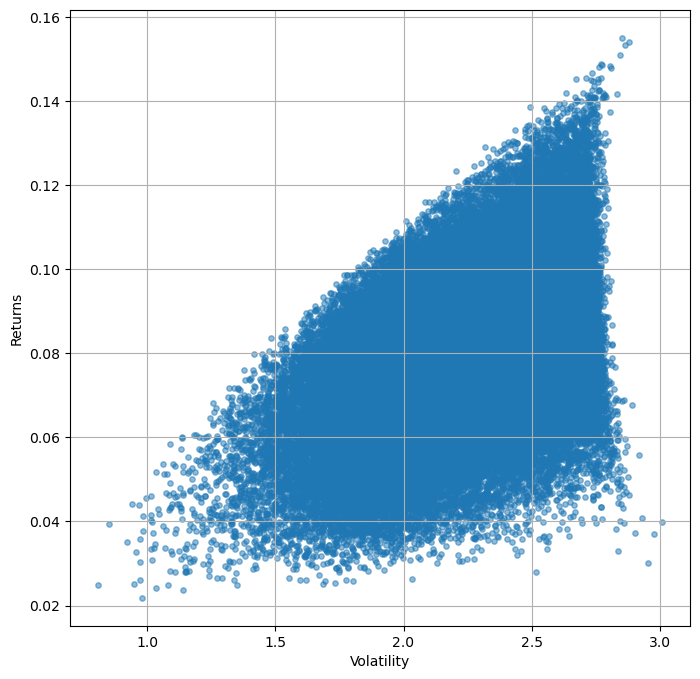

In [58]:
portfolios_V1.plot.scatter(x='Volatility', y='Returns', marker ='o', s = 15, alpha=0.5, grid=True, figsize=[8,8])



### Allocated weights for each of the 3 portfolios based on the analysis above

#### Conservative

BOND: 63%
SPY: 31%
VGK: 2%
SCHE: 0%
VONG: 4%

#### Balanced

BOND: 33%
SPY: 42%
VGK: 8%
SCHE: 5%
VONG: 12%

#### Growth

BOND: 17%
SPY: 36%
VGK: 15%
SCHE: 8%
VONG: 24%

In [26]:
# adding the weights to 3 lists
conservative_weights = [0.63, 0.31, 0.02, 0, 0.04]
balanced_weights = [0.33, 0.42, 0.08, 0.05, 0.12]
growth_weights = [0.17, 0.36, 0.15, 0.08, 0.24]

portfolio_weights = {'conservative': conservative_weights, 'balanced': balanced_weights, 'growth': growth_weights}

In [27]:
# initial investment of 1 million dollars
initial_investment = 1000000

# date of inital investment (first weekday of March 2020)
date_of_initial_investment = '2020-03-02'


In [28]:
portfolio_data = {}
shares = {}

# creating a dictionary of dataframes on each of the ETFs in the portfolio
for i, etf in enumerate(etf_list):
    portfolio_data[etf] = get_etf_info_dated(etf, date_of_initial_investment)
    
    for key, weights in portfolio_weights.items():
        shares[etf, key] = (weights[i] * initial_investment)/portfolio_data[etf].loc[pd.to_datetime(date_of_initial_investment)+ dt.timedelta(days=1), 'close_price']
        portfolio_data[etf][f"{key}_price_value"] = shares[etf, key] * portfolio_data[etf]['close_price']
        portfolio_data[etf][f"{key}_dividend_value"] = shares[etf, key] * portfolio_data[etf]['dividend']
        portfolio_data[etf][f"{key}_value"]= portfolio_data[etf][f"{key}_price_value"] + portfolio_data[etf][f"{key}_dividend_value"]


In [29]:
# turning the weights dicitionary into a dataframe
portfolio_weights_df = pd.DataFrame(portfolio_weights)
# setting the index as the ETF tickers
portfolio_weights_df.index = etf_list
portfolio_weights_df

,conservative,balanced,growth
BOND,0.63,0.33,0.17
SPY,0.31,0.42,0.36
VGK,0.02,0.08,0.15
SCHE,0.00,0.05,0.08
VONG,0.04,0.12,0.24


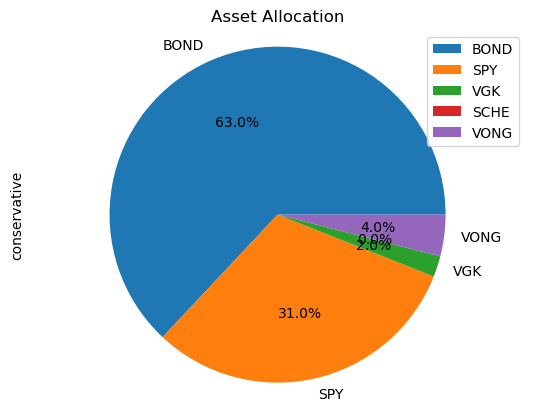

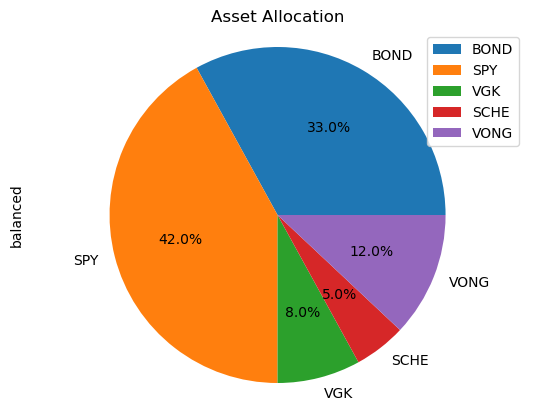

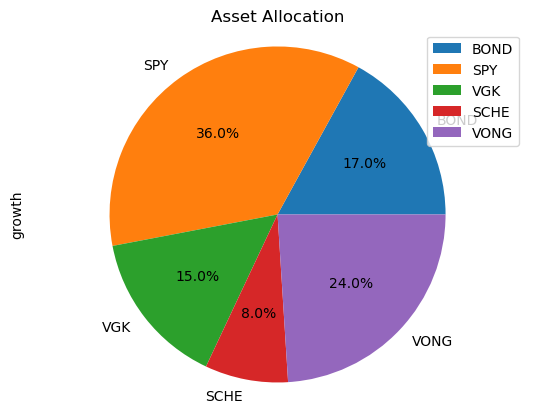

In [30]:
for key in portfolio_weights.keys():
    portfolio_weights_df.plot(kind='pie', y=key, labels = portfolio_weights_df.index, autopct='%1.1f%%', legend=True)
    plt.title('Asset Allocation')
    plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.

In [31]:
# creating a dictionary of dataframes called portfolio, which include dataframes on each kind of portfolio

portfolio = {}
for key in portfolio_weights.keys():
    portfolio[key] = pd.DataFrame(index = portfolio_data[etf_list[0]].index)
    
    for etf in etf_list:
        portfolio[key][f"{etf}_value"] = portfolio_data[etf].loc[ : , f"{key}_value"]
    
    portfolio[key][f"{key}_portfolio_value"] = portfolio[key].iloc[:, :].sum(axis=1)
    pd.set_option('display.float_format', '{:.4f}'.format)
    portfolio[key][f"{key}_portfolio_return"] = portfolio[key][f"{key}_portfolio_value"].pct_change()

In [32]:
portfolio['conservative']

,BOND_value,SPY_value,VGK_value,SCHE_value,VONG_value,conservative_portfolio_value,conservative_portfolio_return
2020-03-03,630000.0000,310000.0000,20000.0000,0.0000,40000.0000,1000000.0000,NaN
2020-03-04,628984.8680,323030.2071,20690.8384,0.0000,41673.3207,1014379.2343,0.0144
2020-03-05,630564.0255,312292.2098,19992.4119,0.0000,40269.0138,1003117.6611,-0.0111
2020-03-06,634624.4109,307129.5826,19719.1170,0.0000,39676.2806,1001149.3911,-0.0020
2020-03-09,638290.1731,283144.5461,18018.6037,0.0000,36856.2692,976309.5921,-0.0248
...,...,...,...,...,...,...,...
2023-09-22,552482.7578,471362.4222,25162.6666,0.0000,64563.5228,1113571.3694,0.0005
2023-09-25,548248.6946,473344.5903,24991.1137,0.0000,64902.1926,1111486.5912,-0.0019
2023-09-26,547626.0005,466390.5590,24678.0281,0.0000,63839.1501,1102533.7376,-0.0081
2023-09-27,546256.1970,466576.7110,24570.8069,0.0000,63933.2235,1101336.9384,-0.0011


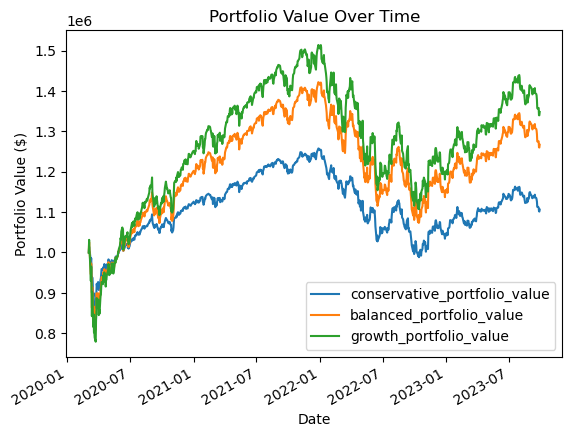

In [33]:
for key in portfolio_weights.keys():
    portfolio[key][f'{key}_portfolio_value'].plot(kind='line', legend=True)
    plt.xlabel('Date')
    plt.ylabel("Portfolio Value ($)")
    plt.title("Portfolio Value Over Time")



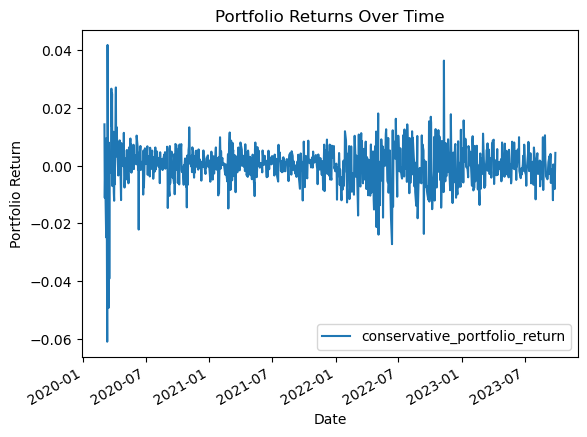

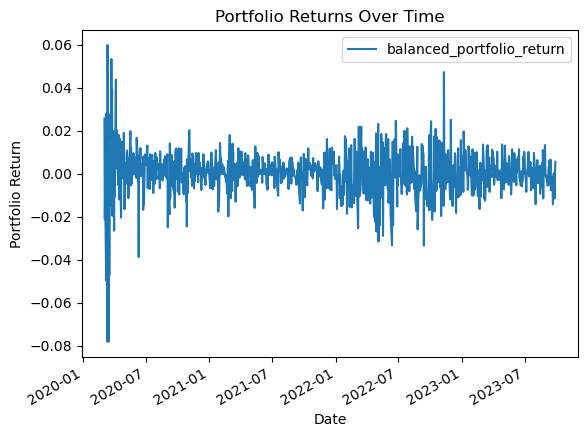

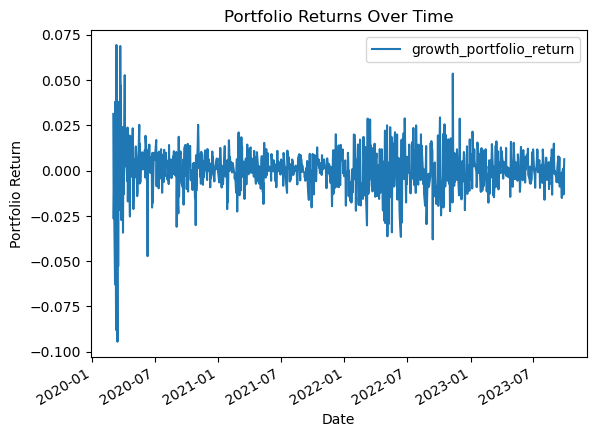

In [34]:
for key in portfolio_weights.keys():
    portfolio[key][f'{key}_portfolio_return'].plot(kind='line', legend=True)
    plt.xlabel('Date')
    plt.ylabel("Portfolio Return")
    plt.title("Portfolio Returns Over Time")
    plt.show()

## Exporting the data into usable JSONs

### Exporting portfolio weights as a JSON

In [35]:
# creating a dictionary of weights that can be JSONified
weights_dict={}

for key in portfolio_weights.keys():
    weights = {}
    
    for i, etf in enumerate(etf_list):
        weights[etf] = portfolio_weights[key][i]
        
    weights_dict[key] = weights

In [36]:
weights_dict

{'conservative': {'BOND': 0.63,
  'SPY': 0.31,
  'VGK': 0.02,
  'SCHE': 0,
  'VONG': 0.04},
 'balanced': {'BOND': 0.33,
  'SPY': 0.42,
  'VGK': 0.08,
  'SCHE': 0.05,
  'VONG': 0.12},
 'growth': {'BOND': 0.17,
  'SPY': 0.36,
  'VGK': 0.15,
  'SCHE': 0.08,
  'VONG': 0.24}}

In [37]:
# JSONifying the weights
portfolio_weights_json = json.dumps(weights_dict)
print(portfolio_weights_json)

{"conservative": {"BOND": 0.63, "SPY": 0.31, "VGK": 0.02, "SCHE": 0, "VONG": 0.04}, "balanced": {"BOND": 0.33, "SPY": 0.42, "VGK": 0.08, "SCHE": 0.05, "VONG": 0.12}, "growth": {"BOND": 0.17, "SPY": 0.36, "VGK": 0.15, "SCHE": 0.08, "VONG": 0.24}}


In [38]:
# export JSON file
with open("portfolio_weights.json", "w") as json_file:
    json.dump(portfolio_weights_json, json_file)

### Exporting historical ETF data as JSONs

In [39]:
# defining a function to add index as a column

def add_index_column(df, new_column_name):
    df.reset_index(inplace=True)
    df.rename(columns={'index': new_column_name}, inplace=True)

In [40]:
# turning the dictionary of dataframes into a dictionary of dictionaries
unclean_etf_info_dict = {}
for etf in etf_list:
    add_index_column(etf_info[etf], 'date')
    unclean_etf_info_dict[etf] = etf_info[etf].to_dict(orient='records')



In [41]:
# function to format datetime objects within the list of dictionaries
def format_datetime_dicts(data):
    formatted_data = []
    for item in data:
        formatted_item = {
            key: value.strftime('%Y-%m-%d') if isinstance(value, Timestamp) else value
            for key, value in item.items()
        }
        formatted_data.append(formatted_item)
    return formatted_data

etf_info_dict={}

for etf in etf_list:
    # Format the timestamp values in the list
    etf_info_dict[etf] = format_datetime_dicts(unclean_etf_info_dict[etf])

# Convert the list of dictionaries to a JSON array
etf_info_json = json.dumps(etf_info_dict, indent=0)



In [42]:
# export etf into as json
with open("etf_price_info.json", "w") as json_file:
    json.dump(etf_info_json, json_file)

### Exporting annualized return and risks of each ETF as JSON

In [43]:
# JSONifying annualized return and risk

annualized_return_json = json.dumps(annualized_return)
annualized_risk_json = json.dumps(annualized_risk)

                                   
# export json
with open("annualized_return.json", "w") as json_file:
    json.dump(annualized_return_json, json_file)
    
with open("annualized_risk.json", "w") as json_file:
    json.dump(annualized_risk_json, json_file)

### Exporting portfolio data as JSON

In [44]:
# turning the dictionary of dataframes into a dictionary of dictionaries
unclean_portfolio_dict = {}

for key in portfolio_weights.keys():
    add_index_column(portfolio[key], 'date')
    unclean_portfolio_dict[key] = portfolio[key].to_dict(orient='records')


In [45]:
portfolio_dict = {}

for key in portfolio_weights.keys():
    # Format the timestamp values in the list
    portfolio_dict[key] = format_datetime_dicts(unclean_portfolio_dict[key])

# Convert the list of dictionaries to a JSON array
portfolio_json = json.dumps(portfolio_dict, indent=0)


In [46]:
# export as json
with open("portfolio.json", "w") as json_file:
    json.dump(portfolio_json, json_file)

### exporting additional ETF information

In [47]:
# getting additional info on ETF
etf_additional_info={}
for etf in etf_list:
    etf_additional_info[etf] = get_analysts_info(etf)[0]


In [48]:
# converting dataframes into dictionary
etf_additional_info_dict = {}
for etf in etf_list:
    etf_additional_info_dict[etf] = etf_additional_info[etf].set_index(0).squeeze().to_dict()
    

In [49]:
# converting dictionaries into JSON
etf_additional_info_json = json.dumps(etf_additional_info_dict)

# export as json
with open("etf_additional_info.json", "w") as json_file:
    json.dump(etf_additional_info_json, json_file)